In [1]:
# UKPN Curtailment Analysis

# 0) Imports and settings
import os
import re
from dataclasses import dataclass
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
from dateutil import parser as dateparser

# Optional: install geopandas/pyproj if you want spatial work. Keeping core deps only for now.

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 220)

WORKDIR = "/Users/aron/project-overflow"
ECR_PATH = os.path.join(WORKDIR, "ukpn-embedded-capacity-register.csv")
EVENTS_PATH = os.path.join(WORKDIR, "ukpn-curtailment-events-site-specific.csv")
RT_CONSTRAINTS_PATH = os.path.join(WORKDIR, "ukpn-constraints-real-time-meter-readings.csv")
BREACHES_PATH = os.path.join(WORKDIR, "ukpn-constraint-breaches-history.csv")

assert os.path.exists(ECR_PATH), f"Missing file: {ECR_PATH}"
assert os.path.exists(EVENTS_PATH), f"Missing file: {EVENTS_PATH}"
assert os.path.exists(RT_CONSTRAINTS_PATH), f"Missing file: {RT_CONSTRAINTS_PATH}"
assert os.path.exists(BREACHES_PATH), f"Missing file: {BREACHES_PATH}"

print("Files located. Ready to proceed.")


Files located. Ready to proceed.


In [2]:
# 1) Helpers for normalization and parsing

NON_ALNUM = re.compile(r"[^A-Z0-9]+")
WHITESPACE = re.compile(r"\s+")


def norm_text(x: Optional[str]) -> str:
    if pd.isna(x):
        return ""
    s = str(x).upper().strip()
    s = WHITESPACE.sub(" ", s)
    return s


def norm_token(x: Optional[str]) -> str:
    s = norm_text(x)
    return NON_ALNUM.sub(" ", s).strip()


def parse_number(x: Optional[str]) -> Optional[float]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x)
    s = s.replace(",", "").strip()
    try:
        # handle units like "99.0 A" or "17.115 %"
        parts = s.split()
        val = float(parts[0])
        return val
    except Exception:
        try:
            return float(s)
        except Exception:
            return None


def parse_duration_hours(x: Optional[str]) -> Optional[float]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip().lower().replace(",", "")
    # formats like "1.693 hours" or "0.524"
    try:
        if "hour" in s:
            num = s.split("hour")[0].strip()
            return float(num)
        return float(s)
    except Exception:
        return None


def parse_kwh(x: Optional[str]) -> Optional[float]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip().lower().replace(",", "")
    # "16,764 kWh" -> 16764
    try:
        num = s.split()[0]
        return float(num)
    except Exception:
        try:
            return float(s)
        except Exception:
            return None


def parse_kw(x: Optional[str]) -> Optional[float]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip().lower().replace(",", "")
    try:
        num = s.split()[0]
        return float(num)
    except Exception:
        try:
            return float(s)
        except Exception:
            return None


def parse_timestamp(x: Optional[str]) -> Optional[pd.Timestamp]:
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return None
    s = str(x).strip()
    try:
        dt = dateparser.parse(s)
        if dt.tzinfo is None:
            return pd.Timestamp(dt).tz_localize("UTC")
        return pd.Timestamp(dt).tz_convert("UTC")
    except Exception:
        return None


def within_tolerance(a: Optional[float], b: Optional[float], pct: float = 0.2, abs_tol: float = 50.0) -> bool:
    if a is None or b is None:
        return False
    if a == 0 and b == 0:
        return True
    if a == 0 or b == 0:
        return False
    return abs(a - b) <= max(abs(a) * pct, abs(b) * pct, abs_tol)


def haversine_km(lat1: Optional[float], lon1: Optional[float], lat2: Optional[float], lon2: Optional[float]) -> Optional[float]:
    if any(v is None or (isinstance(v, float) and np.isnan(v)) for v in [lat1, lon1, lat2, lon2]):
        return None
    # Convert decimal degrees to radians
    rlat1, rlon1, rlat2, rlon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = rlat2 - rlat1
    dlon = rlon2 - rlon1
    a = np.sin(dlat/2.0)**2 + np.cos(rlat1) * np.cos(rlat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371.0088  # Earth mean radius (km)
    return float(R * c)


print("Helper functions defined.")


Helper functions defined.


In [3]:
# 2) Load datasets

# Read raw with all as string to control parsing
raw_ecr = pd.read_csv(ECR_PATH, dtype=str)
raw_events = pd.read_csv(EVENTS_PATH, dtype=str)
raw_rt = pd.read_csv(RT_CONSTRAINTS_PATH, dtype=str)
raw_breaches = pd.read_csv(BREACHES_PATH, dtype=str)

print({
    "ecr_rows": len(raw_ecr),
    "events_rows": len(raw_events),
    "rt_rows": len(raw_rt),
    "breaches_rows": len(raw_breaches),
})

# Normalize ECR
ECR_COL_EXPORT_MW = "Already Connected - Maximum Export Capacity (MW)"
ECR_COL_REGISTERED_MW = "Energy Source & Energy Conversion Technology 1 - Registered Capacity (MW)"


def build_ecr(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Key identity fields
    out["customer_name"] = out.get("Customer Name", "").map(norm_text)
    out["customer_site"] = out.get("Customer Site", "").map(norm_text)
    out["gsp"] = out.get("Grid Supply Point", "").map(norm_text)
    out["bsp"] = out.get("Bulk Supply Point", "").map(norm_text)
    out["primary"] = out.get("Primary", "").map(norm_text)
    out["poc_kv"] = out.get("Point of Connection (POC)_Voltage (kV)", "").map(norm_text)
    out["licence_area"] = out.get("Licence Area", "").map(norm_text)
    out["energy_source1"] = out.get("Energy Source 1", "").map(norm_text)
    out["energy_tech1"] = out.get("Energy Conversion Technology 1", "").map(norm_text)
    out["date_connected"] = out.get("Date Connected", "").map(parse_timestamp)

    # Export capacity kW
    export_mw = out.get(ECR_COL_EXPORT_MW, pd.Series(index=out.index)).map(parse_number)
    reg_mw = out.get(ECR_COL_REGISTERED_MW, pd.Series(index=out.index)).map(parse_number)
    export_mw = export_mw.fillna(reg_mw)
    out["export_capacity_kW"] = export_mw.astype(float) * 1000.0

    # Coordinates if present
    out["latitude"] = out.get("Latitude", "").map(lambda x: parse_number(x))
    out["longitude"] = out.get("Longitude", "").map(lambda x: parse_number(x))

    # Site ID
    out["site_id"] = (
        out["customer_name"].fillna("") + "|" + out["customer_site"].fillna("") + "|" + out["gsp"].fillna("")
    ).apply(lambda s: NON_ALNUM.sub("_", s).strip("_"))

    # Grid tokens used for matching
    for col in ["gsp", "bsp", "primary"]:
        out[f"{col}_token"] = out[col].map(norm_token)

    return out


ecr = build_ecr(raw_ecr)
print("ECR processed:", ecr.shape)

# Normalize Events

def build_events(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["der_name"] = out.get("der_name", "").map(norm_text)
    out["event_id"] = out.get("event_id", "").map(norm_text)
    out["scheme_name"] = out.get("scheme_name", "").map(norm_text)
    out["driver"] = out.get("driver", "").map(norm_text)
    out["public_flag"] = out.get("public_flag", "").map(norm_text)

    out["start_utc"] = out.get("start_time_utc", "").map(parse_timestamp)
    out["end_utc"] = out.get("end_time_utc", "").map(parse_timestamp)

    out["duration_h"] = out.get("duration_hours", "").map(parse_duration_hours)
    out["total_kwh"] = out.get("total_der_access_reduction_kWh", "").map(parse_kwh)
    out["avg_kw"] = out.get("average_access_reduction_kW", "").map(parse_kw)
    out["peak_kw"] = out.get("peak_access_reduction_kW", "").map(parse_kw)

    # Fallback estimate for total_kwh if missing
    mask_missing = out["total_kwh"].isna() & out["avg_kw"].notna() & out["duration_h"].notna()
    out.loc[mask_missing, "total_kwh"] = out.loc[mask_missing, "avg_kw"] * out.loc[mask_missing, "duration_h"]

    # Scheme token for matching (e.g., WALPOLE, BRAMFORD)
    out["scheme_token"] = out["scheme_name"].map(norm_token)

    return out


events = build_events(raw_events)
print("Events processed:", events.shape)

# Normalize Real-time Constraints

def build_rt(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["timestamp_utc"] = out.get("timestamp", "").map(parse_timestamp)
    out["constraint_id"] = out.get("constraint_id", "").map(norm_text)
    out["constraint_description"] = out.get("constraint_description", "").map(norm_text)
    out["der_name"] = out.get("der_name", "").map(norm_text)
    out["utilisation_pct"] = out.get("utilisation_percentage", "").map(parse_number)
    out["trim_limit_amps"] = out.get("trim_limit_amps", "").map(parse_number)
    out["release_limit_amps"] = out.get("release_limit_amps", "").map(parse_number)
    out["breach_flag"] = out.get("breach_flag", "").map(norm_text)

    out["constraint_token"] = out["constraint_description"].map(norm_token)
    return out


rt = build_rt(raw_rt)
print("Real-time constraints processed:", rt.shape)

# Normalize Breaches

def build_breaches(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["scheme"] = out.get("scheme", "").map(norm_text)
    out["event_id"] = out.get("event_id", "").map(norm_text)
    out["constraint_id"] = out.get("constraint_id", "").map(norm_text)
    out["constraint_description"] = out.get("constraint_description", "").map(norm_text)
    out["constraint_voltage_kv"] = out.get("constraint_voltage_kV", "").map(parse_number)

    out["start_utc"] = out.get("start_time_utc", "").map(parse_timestamp)
    out["end_utc"] = out.get("end_time_utc", "").map(parse_timestamp)
    out["duration_h"] = out.get("duration_hours", "").map(parse_duration_hours)
    out["total_kwh"] = out.get("total_der_access_reduction_kWh", "").map(parse_kwh)

    out["scheme_token"] = out["scheme"].map(norm_token)
    out["constraint_token"] = out["constraint_description"].map(norm_token)
    return out


breaches = build_breaches(raw_breaches)
print("Breaches processed:", breaches.shape)

# Analysis range
overall_start = min(ts for ts in [events["start_utc"].min(), breaches["start_utc"].min()] if pd.notna(ts))
overall_end = max(ts for ts in [events["end_utc"].max(), breaches["end_utc"].max()] if pd.notna(ts))
print("Analysis window UTC:", overall_start, "->", overall_end)


{'ecr_rows': 1240, 'events_rows': 12112, 'rt_rows': 159, 'breaches_rows': 13214}
ECR processed: (1240, 79)
Events processed: (12112, 21)
Real-time constraints processed: (159, 12)
Breaches processed: (13214, 18)
Analysis window UTC: 2023-01-01 01:11:01+00:00 -> 2025-08-25 23:00:00+00:00


In [4]:
# 3) DER -> Site mapping via scoring

from collections import defaultdict

OUTPUT_DIR = os.path.join(WORKDIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Precompute ECR lookup with minimal columns
site_cols = [
    "site_id","customer_name","customer_site","gsp","bsp","primary","poc_kv",
    "gsp_token","bsp_token","primary_token","export_capacity_kW","latitude","longitude"
]
ecr_lite = ecr[site_cols].copy()

# Build simple centroids for grid tokens (based on ECR sites with lat/lon)
for token_col in ["gsp_token", "bsp_token", "primary_token"]:
    has_geo = ecr_lite[[token_col, "latitude", "longitude"]].dropna()
    centroids = (
        has_geo.groupby(token_col)[["latitude", "longitude"]]
        .mean()
        .rename(columns={"latitude": f"{token_col}_lat", "longitude": f"{token_col}_lon"})
        .reset_index()
    )
    ecr_lite = ecr_lite.merge(centroids, on=token_col, how="left")

# Breach index by scheme_token for quick overlap checks
breaches_idx = breaches.set_index(breaches["scheme_token"].fillna("")).groupby(level=0)


def event_overlaps_breach(event_row: pd.Series) -> bool:
    st, et = event_row["start_utc"], event_row["end_utc"]
    token = event_row["scheme_token"] or ""
    if pd.isna(st) or pd.isna(et) or token == "":
        return False
    try:
        group = breaches_idx.get_group(token)
    except KeyError:
        return False
    # Overlap if breach interval intersects event interval by any positive duration
    overlap = ((group["start_utc"] <= et) & (group["end_utc"] >= st)).any()
    return bool(overlap)


def grid_token_overlap_score(scheme_token: str, site_row: pd.Series) -> float:
    if not scheme_token:
        return 0.0
    tokens = [t for t in scheme_token.split() if len(t) >= 3]
    if not tokens:
        return 0.0
    site_tokens = set((site_row["gsp_token"] + " " + site_row["bsp_token"] + " " + site_row["primary_token"]).split())
    hits = sum(1 for t in tokens if t in site_tokens)
    return hits / max(len(tokens), 1)


def capacity_similarity_score(event_peak_kw: Optional[float], site_capacity_kw: Optional[float]) -> float:
    if event_peak_kw is None or np.isnan(event_peak_kw) or site_capacity_kw is None or np.isnan(site_capacity_kw):
        return 0.0
    if event_peak_kw == 0 or site_capacity_kw == 0:
        return 0.0
    ratio = min(event_peak_kw, site_capacity_kw) / max(event_peak_kw, site_capacity_kw)
    return float(ratio)  # 1.0 if equal, decays towards 0


def breach_overlap_score(event_row: pd.Series) -> float:
    return 1.0 if event_overlaps_breach(event_row) else 0.0


def spatial_proximity_score(scheme_token: str, site_row: pd.Series) -> float:
    # Use centroid of best-matching token among gsp/bsp/primary based on overlap with scheme tokens
    if not scheme_token:
        return 0.0
    tokens = set(t for t in scheme_token.split() if len(t) >= 3)
    # Decide which token is the best match
    candidates = []
    for level in ["gsp_token", "bsp_token", "primary_token"]:
        site_tokens = set((site_row[level] or "").split())
        overlap = len(tokens & site_tokens)
        lat = site_row.get(f"{level}_lat", np.nan)
        lon = site_row.get(f"{level}_lon", np.nan)
        candidates.append((overlap, level, lat, lon))
    # pick with largest overlap, fallback to any available centroid
    candidates.sort(reverse=True)
    for _, level, lat, lon in candidates:
        if pd.notna(lat) and pd.notna(lon):
            # Distance from site point to centroid itself is 0 (site near its own area)
            # Since we don't have a separate constraint centroid, approximate by distance to area centroid (here identical)
            # Instead we compute distance from site to its area centroid for normalization.
            # Use small distance -> higher score.
            dkm = haversine_km(site_row.get("latitude"), site_row.get("longitude"), lat, lon)
            if dkm is None:
                continue
            # score: 1 at 0 km; decays to ~0 by 50 km
            return float(max(0.0, 1.0 - (dkm / 50.0)))
    return 0.0


# Weights (now include spatial)
W_CAPACITY = 0.45
W_GRID = 0.35
W_BREACH = 0.05
W_SPATIAL = 0.15

# Candidate pruning: First narrow by grid token overlap > 0 for efficiency; if none, consider all with capacity signal only


der_to_site_scores: Dict[Tuple[str, str], float] = defaultdict(float)  # (der_name, site_id) -> cumulative score

der_events = events.groupby("der_name")

for der, df_der in der_events:
    if der == "" or df_der.empty:
        continue

    # Pre-collect any candidate sites with grid token match
    cand_site_ids = set()
    for _, ev in df_der.iterrows():
        scheme_token = ev.get("scheme_token", "")
        if not scheme_token:
            continue
        # quick filter: any site with token hit in gsp/bsp/primary
        hits = ecr_lite[ecr_lite.apply(lambda r: grid_token_overlap_score(scheme_token, r) > 0.0, axis=1)]
        cand_site_ids.update(hits["site_id"].tolist())

    if not cand_site_ids:
        # fallback to all sites (will rely on capacity similarity)
        cand_site_ids = set(ecr_lite["site_id"].tolist())

    # Build a site lookup for candidates
    cand_sites = ecr_lite[ecr_lite["site_id"].isin(cand_site_ids)].copy()

    # Score accumulation per event
    for _, ev in df_der.iterrows():
        peak_kw = ev.get("peak_kw", np.nan)
        scheme_token = ev.get("scheme_token", "")
        s_breach = breach_overlap_score(ev)
        for _, site in cand_sites.iterrows():
            s_grid = grid_token_overlap_score(scheme_token, site)
            s_cap = capacity_similarity_score(peak_kw, site["export_capacity_kW"])
            s_sp = spatial_proximity_score(scheme_token, site)
            score = W_CAPACITY * s_cap + W_GRID * s_grid + W_BREACH * s_breach + W_SPATIAL * s_sp
            if score > 0:
                der_to_site_scores[(der, site["site_id"])] += score

# Consolidate scores to mapping
rows = []
for (der, site_id), score in der_to_site_scores.items():
    rows.append({"der_name": der, "site_id": site_id, "score": score})

map_df = pd.DataFrame(rows)

# Pick best site per der
if not map_df.empty:
    map_df["rank"] = map_df.groupby("der_name")["score"].rank(ascending=False, method="first")
    top_map = map_df[map_df["rank"] == 1.0].copy()
    # Confidence: ratio of top to sum for that der
    sums = map_df.groupby("der_name")["score"].sum().rename("score_sum")
    top_map = top_map.merge(sums, on="der_name", how="left")
    top_map["confidence"] = top_map["score"] / top_map["score_sum"].replace(0, np.nan)
    top_map = top_map.drop(columns=["rank", "score_sum"]).sort_values(["confidence"], ascending=False)
else:
    top_map = pd.DataFrame(columns=["der_name","site_id","score","confidence"])  # empty fallback

# Attach site details
mapped = top_map.merge(ecr_lite, on="site_id", how="left")

# Export mapping
map_path = os.path.join(OUTPUT_DIR, "der_to_site_map.csv")
mapped.to_csv(map_path, index=False)
print(f"DER->Site mapping saved: {map_path}; rows={len(mapped)}")

mapped.head(10)


DER->Site mapping saved: /Users/aron/project-overflow/outputs/der_to_site_map.csv; rows=59


,der_name,site_id,score,confidence,customer_name,customer_site,gsp,bsp,primary,poc_kv,gsp_token,bsp_token,primary_token,export_capacity_kW,latitude,longitude,gsp_token_lat,gsp_token_lon,bsp_token_lat,bsp_token_lon,primary_token_lat,primary_token_lon
0,DER28,ANESCO_ANM_BISHOPSTONE_AMERSHAM,10.977667,0.102705,ANESCO,(ANM) BISHOPSTONE,AMERSHAM,ILMER GRID 33KV,,33.0,AMERSHAM,ILMER GRID 33KV,,19960.0,51.784300,-0.815161,51.742427,-0.870566,51.758044,-0.889250,51.897870,0.388533
1,DER44,STARK_ENERGY_ANM_WHIRLBUSH_FARM_AMERSHAM,18.691064,0.101512,STARK ENERGY,(ANM) WHIRLBUSH FARM,AMERSHAM,-,,132.0,AMERSHAM,,,36000.0,51.699565,-0.893603,51.742427,-0.870566,51.765793,0.276240,51.897870,0.388533
2,DER42,TUPA_SOLAR_1_LIMITED_RICHBOROUGH_ENERGY_PARK_S...,59.656304,0.038351,TUPA SOLAR 1 LIMITED,RICHBOROUGH ENERGY PARK,SELLINDGE SGT2 & 3 & RICHBOROUGH SGT,-,,132.0,SELLINDGE SGT2 3 RICHBOROUGH SGT,,,49900.0,51.307846,1.346016,51.236787,1.196255,51.765793,0.276240,51.897870,0.388533
3,DER42,TUPA_SOLAR_1_LIMITED_RICHBOROUGH_ENERGY_PARK_S...,59.656304,0.038351,TUPA SOLAR 1 LIMITED,RICHBOROUGH ENERGY PARK,SELLINDGE SGT2 & 3 & RICHBOROUGH SGT,-,RICHBOROUGH 132KV,132.0,SELLINDGE SGT2 3 RICHBOROUGH SGT,,RICHBOROUGH 132KV,49900.0,51.310180,1.348697,51.236787,1.196255,51.765793,0.276240,51.295911,1.323297
4,DER32,NOVENTUM_POWER_LTD_ANM_WALES_END_FARM_PELHAM,3.623951,0.031057,NOVENTUM POWER LTD,(ANM) WALES END FARM,PELHAM,BELCHAMP GRID 33KV,,33.0,PELHAM,BELCHAMP GRID 33KV,,12500.0,52.116476,0.621986,51.972322,0.342823,52.081597,0.587692,51.897870,0.388533
5,DER32,NOVENTUM_POWER_LTD_ANM_WALES_END_FARM_PELHAM,3.623951,0.031057,NOVENTUM POWER LTD,(ANM) WALES END FARM,PELHAM,BELCHAMP GRID 132/33KV,,33.0,PELHAM,BELCHAMP GRID 132 33KV,,10400.0,52.111366,0.621715,51.972322,0.342823,52.077709,0.602912,51.897870,0.388533
6,DER30,YORK_GREEN_RENEWABLES_LTD_GALLEY_HILL_FARM_EAT...,1.590417,0.030268,YORK GREEN RENEWABLES LTD,GALLEY HILL FARM,EATON SOCON,HUNTINGDON GRID 33KV,GODMANCHESTER PRIMARY 11KV,11.0,EATON SOCON,HUNTINGDON GRID 33KV,GODMANCHESTER PRIMARY 11KV,1000.0,52.307700,-0.109412,52.284858,-0.198946,52.383059,-0.139203,52.307700,-0.109412
7,DER13,AGR_PEAK_POWER_LTD_FDG_F_04_CHEAR_FARM_BURWELL,152.316413,0.028718,AGR PEAK POWER LTD,FDG F-04 CHEAR FARM,BURWELL,HISTON GRID 33KV,,33.0,BURWELL,HISTON GRID 33KV,,15000.0,52.328143,0.202150,52.269614,0.236707,52.310841,0.167905,51.897870,0.388533
8,DER21,RENEWABLE_CONNECTIONS_DEVELOPMENTS_LTD_ANM_GRE...,161.003916,0.024665,RENEWABLE CONNECTIONS DEVELOPMENTS LTD,(ANM) GREEN END,BURWELL MAIN GRID 132KV,HISTON GRID 132/33KV,LANDBEACH SW/STN 33KV,33.0,BURWELL MAIN GRID 132KV,HISTON GRID 132 33KV,LANDBEACH SW STN 33KV,25000.0,52.269034,0.162094,52.239497,0.193053,52.270542,0.083797,52.269034,0.162094
9,DER26,GEW2_LTD_ASHINGDON_CANEWDON_PV_ULVERSTON_ROCHF...,97.655846,0.024324,GEW2 LTD,ASHINGDON / CANEWDON PV ULVERSTON ROCHFORD,RAYLEIGH,SOUTHEND GRID 33KV,,33.0,RAYLEIGH,SOUTHEND GRID 33KV,,10000.0,51.619082,0.690422,51.694020,0.680816,51.619082,0.690422,51.897870,0.388533


In [5]:
# 4) Per-site metrics and rankings

# Join events -> mapped site
if mapped.empty:
    print("No DER->Site mapping generated; metrics will be empty.")
    site_events = events.assign(site_id=np.nan)
else:
    site_map = mapped[["der_name","site_id","confidence"]].copy()
    site_events = events.merge(site_map, on="der_name", how="left")

# Keep only events with non-zero energy/kw and with a mapped site
valid = site_events[(site_events["site_id"].notna()) & ((site_events["total_kwh"].fillna(0) > 0) | (site_events["avg_kw"].fillna(0) > 0) | (site_events["peak_kw"].fillna(0) > 0))].copy()

# Compute additional fields
valid["year_month"] = valid["start_utc"].dt.tz_convert("UTC").dt.to_period("M").astype(str)
valid["event_hours"] = valid["duration_h"].fillna(0)
valid["total_kwh_est"] = valid["total_kwh"].fillna(valid["avg_kw"].fillna(0) * valid["event_hours"])  # fallback

# Attach site capacity
valid = valid.merge(ecr_lite[["site_id","export_capacity_kW","gsp","bsp","primary","customer_name","customer_site","latitude","longitude"]], on="site_id", how="left")

# Aggregate per site
agg = valid.groupby("site_id").agg(
    events_count=("event_id", "nunique"),
    total_hours=("event_hours", "sum"),
    total_kwh=("total_kwh_est", "sum"),
    median_event_hours=("event_hours", "median"),
    p90_event_hours=("event_hours", lambda s: float(np.nanpercentile(s.fillna(0), 90))),
    median_peak_ratio=("peak_kw", lambda s: float(np.nanmedian(s / valid.loc[s.index, "export_capacity_kW"].replace(0, np.nan)) if len(s) else np.nan)),
).reset_index()

# Add per-MW normalization
agg = agg.merge(ecr_lite[["site_id","export_capacity_kW","gsp","bsp","primary","customer_name","customer_site","latitude","longitude"]], on="site_id", how="left")
agg["curtailed_kwh_per_MW"] = agg["total_kwh"] / (agg["export_capacity_kW"].replace(0, np.nan) / 1000.0)
agg["events_per_month"] = valid.groupby("site_id")["year_month"].nunique().reindex(agg["site_id"]).values / max(len(valid["year_month"].unique()), 1)

# Composite rank using manual min-max scaling (avoid external deps)
components = {
    "events_count": agg["events_count"].fillna(0).values.astype(float),
    "total_hours": agg["total_hours"].fillna(0).values.astype(float),
    "total_kwh": agg["total_kwh"].fillna(0).values.astype(float),
    "curtailed_kwh_per_MW": agg["curtailed_kwh_per_MW"].fillna(0).values.astype(float),
}

scaled = []
for name, arr in components.items():
    if arr.size == 0:
        scaled.append(arr)
        continue
    mn = np.nanmin(arr)
    mx = np.nanmax(arr)
    if not np.isfinite(mn) or not np.isfinite(mx) or mx == mn:
        scaled.append(np.zeros_like(arr))
    else:
        scaled.append((arr - mn) / (mx - mn))

X = np.vstack(scaled).T if scaled else np.empty((len(agg), 0))
agg["composite_index"] = X.mean(axis=1) if X.size else 0.0

ranked = agg.sort_values("composite_index", ascending=False).reset_index(drop=True)

# Export
sites_path = os.path.join(OUTPUT_DIR, "site_curtailment_metrics.csv")
ranked.to_csv(sites_path, index=False)
print(f"Site metrics saved: {sites_path}; rows={len(ranked)}")

ranked.head(10)


Site metrics saved: /Users/aron/project-overflow/outputs/site_curtailment_metrics.csv; rows=30


/var/folders/h_/x7pgt5y16wzgbstmhgljvhp00000gl/T/ipykernel_93573/377100290.py:15: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  valid["year_month"] = valid["start_utc"].dt.tz_convert("UTC").dt.to_period("M").astype(str)


,site_id,events_count,total_hours,total_kwh,median_event_hours,p90_event_hours,median_peak_ratio,export_capacity_kW,gsp,bsp,primary,customer_name,customer_site,latitude,longitude,curtailed_kwh_per_MW,events_per_month,composite_index
0,ANGLIAN_WATER_SERVICES_LTD_FLAG_FEN_SEWAGE_TRE...,5896,32233.854604,1.265294e+08,0.116389,1.060556,1.924666,1200.0,WALPOLE,-,PETERBOROUGH EAST GRID 11KV,ANGLIAN WATER SERVICES LTD,FLAG FEN SEWAGE TREATMENT WORKS,52.569553,-0.200030,1.054412e+08,1.00000,1.000000
1,ANGLIAN_WATER_SERVICES_LTD_FLAG_FEN_SEWAGE_TRE...,5896,32233.854604,1.265294e+08,0.116389,1.060556,1.924666,2500.0,WALPOLE,-,PETERBOROUGH EAST GRID 11KV,ANGLIAN WATER SERVICES LTD,FLAG FEN SEWAGE TREATMENT WORKS,52.569553,-0.200030,5.061175e+07,1.00000,0.870000
2,TUPA_SOLAR_1_LIMITED_RICHBOROUGH_ENERGY_PARK_S...,45,12936.624858,1.586785e+07,0.875556,268.320278,0.421844,49900.0,SELLINDGE SGT2 & 3 & RICHBOROUGH SGT,-,,TUPA SOLAR 1 LIMITED,RICHBOROUGH ENERGY PARK,51.307846,1.346016,3.179930e+05,0.50000,0.134262
3,TUPA_SOLAR_1_LIMITED_RICHBOROUGH_ENERGY_PARK_S...,45,12936.624858,1.586785e+07,0.875556,268.320278,0.421844,49900.0,SELLINDGE SGT2 & 3 & RICHBOROUGH SGT,-,RICHBOROUGH 132KV,TUPA SOLAR 1 LIMITED,RICHBOROUGH ENERGY PARK,51.310180,1.348697,3.179930e+05,0.50000,0.134262
4,LOW_CARBON_ANM_PEMBERTON_SOLAR_FARM_RAYLEIGH,1262,1334.818396,9.876941e+06,0.164167,1.440111,0.244638,20000.0,RAYLEIGH,MALDON GRID 33KV,,LOW CARBON,(ANM) PEMBERTON SOLAR FARM,51.705773,0.649968,4.938471e+05,0.25000,0.084479
5,SOLARCENTURY_HOLDINGS_LIMITED_FDG_B_12_LAND_NE...,272,1402.693680,6.629199e+06,0.467500,12.570000,1.002597,3850.0,NORWICH MAIN,THORPE GRID 33KV,,SOLARCENTURY HOLDINGS LIMITED,FDG B-12 LAND NEAR PERCH LAKE,52.777727,1.227764,1.721870e+06,0.93750,0.039509
6,PETERS_ENERGY_STORAGE_FACILITY_ANM_WALNUT_ROAD...,71,3088.082361,2.018018e+06,0.264444,0.912500,0.292585,49900.0,WALPOLE,-,,PETERS ENERGY STORAGE FACILITY,(ANM)WALNUT ROAD,52.722062,0.221146,4.044123e+04,0.59375,0.030957
7,PETERS_ENERGY_STORAGE_FACILITY_ANM_WALNUT_ROAD...,71,3088.082361,2.018018e+06,0.264444,0.912500,0.292585,49900.0,WALPOLE,-,,PETERS ENERGY STORAGE FACILITY,(ANM)WALNUT ROAD,52.720130,0.220145,4.044123e+04,0.59375,0.030957
8,AGR_PEAK_POWER_LTD_FDG_F_04_CHEAR_FARM_BURWELL,167,335.637573,4.727993e+06,0.478056,5.649462,0.993333,15000.0,BURWELL,HISTON GRID 33KV,,AGR PEAK POWER LTD,FDG F-04 CHEAR FARM,52.328143,0.202150,3.151995e+05,0.93750,0.019687
9,RENEWABLE_CONNECTIONS_DEVELOPMENTS_LTD_ANM_GRE...,190,261.667494,4.446808e+06,0.493194,3.439437,0.755377,25000.0,BURWELL MAIN GRID 132KV,HISTON GRID 132/33KV,LANDBEACH SW/STN 33KV,RENEWABLE CONNECTIONS DEVELOPMENTS LTD,(ANM) GREEN END,52.269034,0.162094,1.778723e+05,0.18750,0.019208


In [6]:
# 5) Window profiles (hour, weekday, month)

if valid.empty:
    print("No valid events for window profiling.")
else:
    # Localize to Europe/London for commercial windows
    valid_local = valid.copy()
    valid_local["start_local"] = valid_local["start_utc"].dt.tz_convert("Europe/London")
    valid_local["hour"] = valid_local["start_local"].dt.hour
    valid_local["weekday"] = valid_local["start_local"].dt.weekday  # 0=Mon
    valid_local["month"] = valid_local["start_local"].dt.month

    # Prepare aggregates
    def agg_dim(dim: str):
        g = valid_local.groupby(["site_id", dim]).agg(
            events_count=("event_id", "nunique"),
            total_hours=("event_hours", "sum"),
            total_kwh=("total_kwh_est", "sum"),
        ).reset_index()
        return g

    by_hour = agg_dim("hour")
    by_weekday = agg_dim("weekday")
    by_month = agg_dim("month")

    # Export all-site profiles
    by_hour.to_csv(os.path.join(OUTPUT_DIR, "site_window_by_hour.csv"), index=False)
    by_weekday.to_csv(os.path.join(OUTPUT_DIR, "site_window_by_weekday.csv"), index=False)
    by_month.to_csv(os.path.join(OUTPUT_DIR, "site_window_by_month.csv"), index=False)

    # Top sites focus
    top_n = min(20, len(ranked))
    top_sites = set(ranked.head(top_n)["site_id"].tolist())
    by_hour_top = by_hour[by_hour["site_id"].isin(top_sites)]
    by_weekday_top = by_weekday[by_weekday["site_id"].isin(top_sites)]
    by_month_top = by_month[by_month["site_id"].isin(top_sites)]

    by_hour_top.to_csv(os.path.join(OUTPUT_DIR, "top_sites_window_by_hour.csv"), index=False)
    by_weekday_top.to_csv(os.path.join(OUTPUT_DIR, "top_sites_window_by_weekday.csv"), index=False)
    by_month_top.to_csv(os.path.join(OUTPUT_DIR, "top_sites_window_by_month.csv"), index=False)

    print("Window profiles saved to outputs/.")


Window profiles saved to outputs/.


Top 20 sites by composite_index:


,customer_name,customer_site,gsp,export_capacity_kW,events_count,total_hours,total_kwh,curtailed_kwh_per_MW,composite_index
1,ANGLIAN WATER SERVICES LTD,FLAG FEN SEWAGE TREATMENT WORKS,WALPOLE,1200.0,5896,32233.854604,1.265294e+08,1.054412e+08,1.000000
2,ANGLIAN WATER SERVICES LTD,FLAG FEN SEWAGE TREATMENT WORKS,WALPOLE,2500.0,5896,32233.854604,1.265294e+08,5.061175e+07,0.870000
3,TUPA SOLAR 1 LIMITED,RICHBOROUGH ENERGY PARK,SELLINDGE SGT2 & 3 & RICHBOROUGH SGT,49900.0,45,12936.624858,1.586785e+07,3.179930e+05,0.134262
4,TUPA SOLAR 1 LIMITED,RICHBOROUGH ENERGY PARK,SELLINDGE SGT2 & 3 & RICHBOROUGH SGT,49900.0,45,12936.624858,1.586785e+07,3.179930e+05,0.134262
5,LOW CARBON,(ANM) PEMBERTON SOLAR FARM,RAYLEIGH,20000.0,1262,1334.818396,9.876941e+06,4.938471e+05,0.084479
6,SOLARCENTURY HOLDINGS LIMITED,FDG B-12 LAND NEAR PERCH LAKE,NORWICH MAIN,3850.0,272,1402.693680,6.629199e+06,1.721870e+06,0.039509
7,PETERS ENERGY STORAGE FACILITY,(ANM)WALNUT ROAD,WALPOLE,49900.0,71,3088.082361,2.018018e+06,4.044123e+04,0.030957
8,PETERS ENERGY STORAGE FACILITY,(ANM)WALNUT ROAD,WALPOLE,49900.0,71,3088.082361,2.018018e+06,4.044123e+04,0.030957
9,AGR PEAK POWER LTD,FDG F-04 CHEAR FARM,BURWELL,15000.0,167,335.637573,4.727993e+06,3.151995e+05,0.019687
10,RENEWABLE CONNECTIONS DEVELOPMENTS LTD,(ANM) GREEN END,BURWELL MAIN GRID 132KV,25000.0,190,261.667494,4.446808e+06,1.778723e+05,0.019208


Saved: /Users/aron/project-overflow/outputs/summary_top_sites.csv


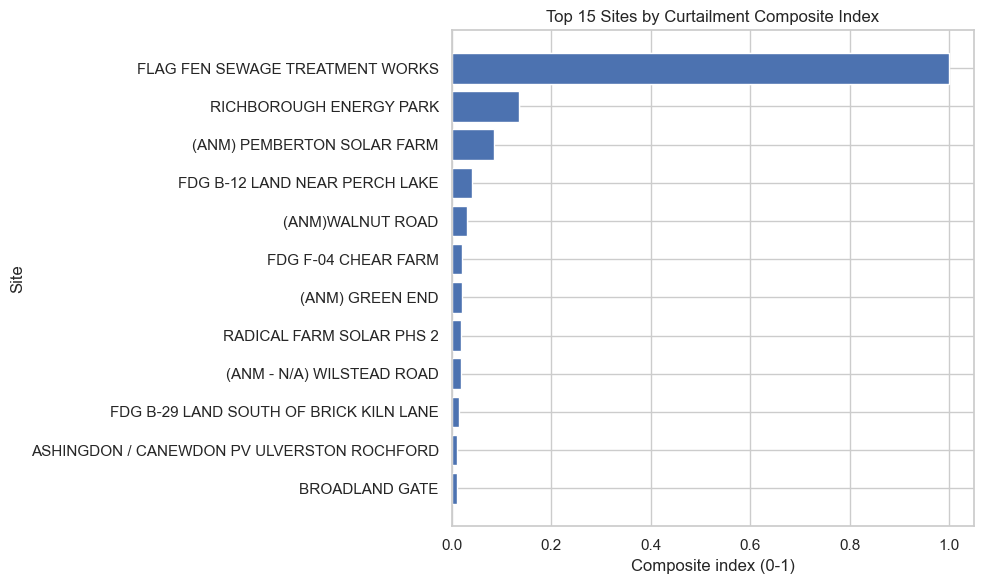

Saved: /Users/aron/project-overflow/outputs/summary_top15_composite_index.png


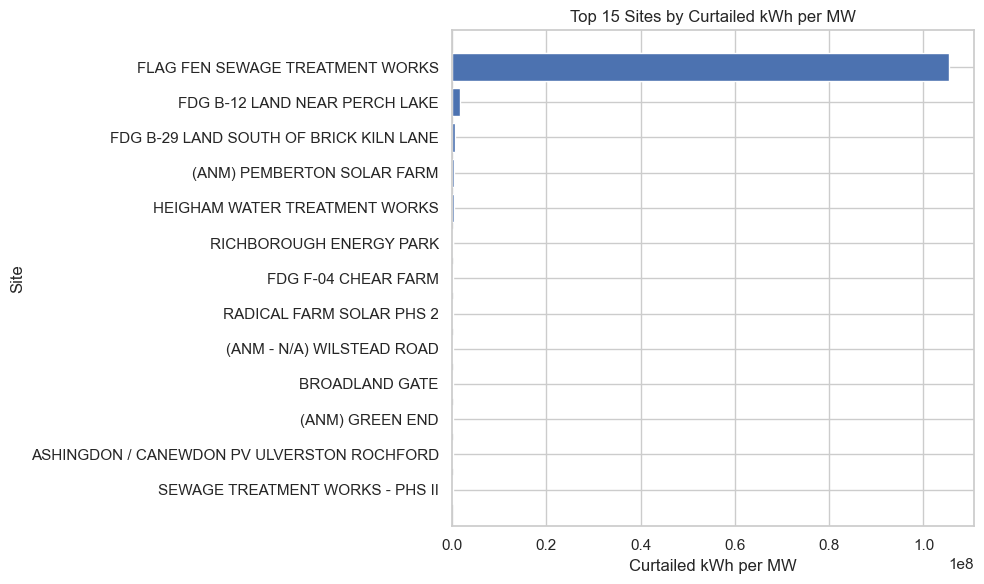

Saved: /Users/aron/project-overflow/outputs/summary_top15_kwh_per_MW.png


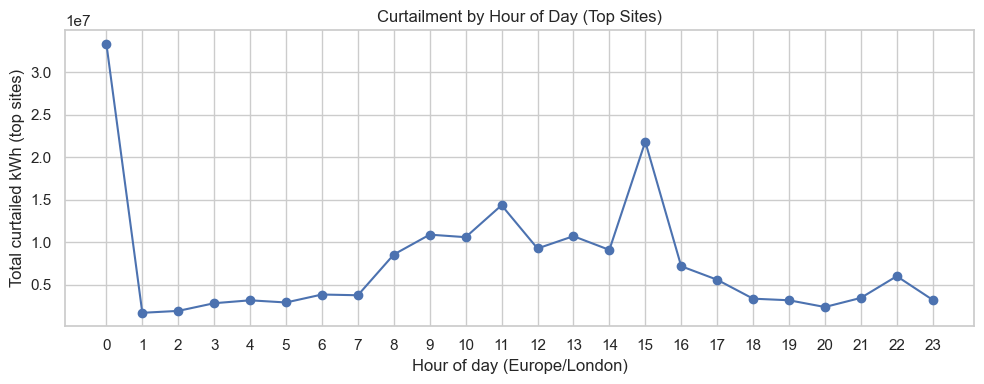

Saved: /Users/aron/project-overflow/outputs/profile_hour_top_sites.png


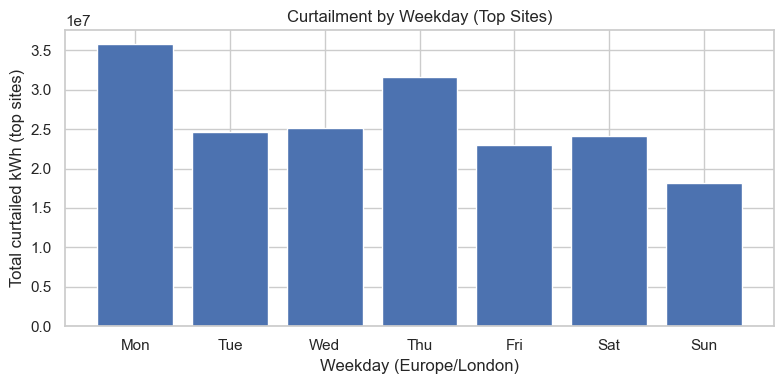

Saved: /Users/aron/project-overflow/outputs/profile_weekday_top_sites.png


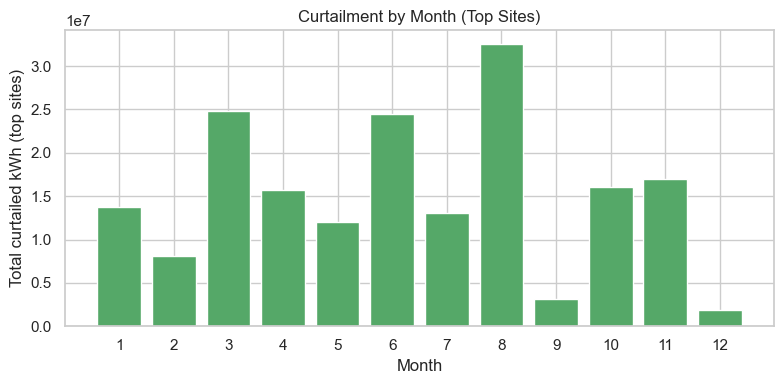

Saved: /Users/aron/project-overflow/outputs/profile_month_top_sites.png


In [7]:
# 6) Reporting: tables and visualizations from outputs

import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except Exception:
    sns = None

out_dir = OUTPUT_DIR

# Load outputs
sites = pd.read_csv(os.path.join(out_dir, "site_curtailment_metrics.csv"))
by_hour_top = pd.read_csv(os.path.join(out_dir, "top_sites_window_by_hour.csv"))
by_weekday_top = pd.read_csv(os.path.join(out_dir, "top_sites_window_by_weekday.csv"))
by_month_top = pd.read_csv(os.path.join(out_dir, "top_sites_window_by_month.csv"))

# Prepare top sites table
sites_cols = [
    "site_id","customer_name","customer_site","gsp","bsp","primary",
    "export_capacity_kW","events_count","total_hours","total_kwh","curtailed_kwh_per_MW",
    "median_event_hours","p90_event_hours","composite_index"
]
for c in sites_cols:
    if c not in sites.columns:
        sites[c] = np.nan

sites_ranked = sites.sort_values("composite_index", ascending=False).reset_index(drop=True)
sites_ranked.index = sites_ranked.index + 1

# Display top 20 in notebook
display_cols = [
    "customer_name","customer_site","gsp","export_capacity_kW","events_count","total_hours",
    "total_kwh","curtailed_kwh_per_MW","composite_index"
]
print("Top 20 sites by composite_index:")
display(sites_ranked[display_cols].head(20))

# Save top 50 summary CSV
summary_csv = os.path.join(out_dir, "summary_top_sites.csv")
sites_ranked.head(50)[sites_cols].to_csv(summary_csv, index_label="rank")
print(f"Saved: {summary_csv}")

# Charts directory

# 1) Top 15 sites by composite index
fig, ax = plt.subplots(figsize=(10, 6))
top15 = sites_ranked.head(15)
ax.barh(top15["customer_site"].fillna(top15["site_id"]).astype(str)[::-1], top15["composite_index"][::-1])
ax.set_xlabel("Composite index (0-1)")
ax.set_ylabel("Site")
ax.set_title("Top 15 Sites by Curtailment Composite Index")
fig.tight_layout()
fig_path = os.path.join(out_dir, "summary_top15_composite_index.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print(f"Saved: {fig_path}")

# 2) Top 15 by curtailed_kwh_per_MW
fig, ax = plt.subplots(figsize=(10, 6))
top15_kwh_per_mw = sites_ranked.sort_values("curtailed_kwh_per_MW", ascending=False).head(15)
ax.barh(top15_kwh_per_mw["customer_site"].fillna(top15_kwh_per_mw["site_id"]).astype(str)[::-1], top15_kwh_per_mw["curtailed_kwh_per_MW"][::-1])
ax.set_xlabel("Curtailed kWh per MW")
ax.set_ylabel("Site")
ax.set_title("Top 15 Sites by Curtailed kWh per MW")
fig.tight_layout()
fig_path = os.path.join(out_dir, "summary_top15_kwh_per_MW.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print(f"Saved: {fig_path}")

# Aggregate window profiles across top sites
hour_agg = by_hour_top.groupby("hour")["total_kwh"].sum().reset_index()
weekday_agg = by_weekday_top.groupby("weekday")["total_kwh"].sum().reset_index()
month_agg = by_month_top.groupby("month")["total_kwh"].sum().reset_index()

# 3) Hour-of-day profile (kWh)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hour_agg["hour"], hour_agg["total_kwh"], marker="o")
ax.set_xticks(range(0, 24, 1))
ax.set_xlabel("Hour of day (Europe/London)")
ax.set_ylabel("Total curtailed kWh (top sites)")
ax.set_title("Curtailment by Hour of Day (Top Sites)")
fig.tight_layout()
fig_path = os.path.join(out_dir, "profile_hour_top_sites.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print(f"Saved: {fig_path}")

# 4) Weekday profile (kWh)
weekday_labels = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(weekday_agg["weekday"], weekday_agg["total_kwh"], color="#4C72B0")
ax.set_xticks(range(7))
ax.set_xticklabels(weekday_labels)
ax.set_xlabel("Weekday (Europe/London)")
ax.set_ylabel("Total curtailed kWh (top sites)")
ax.set_title("Curtailment by Weekday (Top Sites)")
fig.tight_layout()
fig_path = os.path.join(out_dir, "profile_weekday_top_sites.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print(f"Saved: {fig_path}")

# 5) Month profile (kWh)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(month_agg["month"], month_agg["total_kwh"], color="#55A868")
ax.set_xticks(range(1, 13))
ax.set_xlabel("Month")
ax.set_ylabel("Total curtailed kWh (top sites)")
ax.set_title("Curtailment by Month (Top Sites)")
fig.tight_layout()
fig_path = os.path.join(out_dir, "profile_month_top_sites.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print(f"Saved: {fig_path}")

